In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (4))
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
# Circle: returns true if (px, py) is inside the circle of radius r centered at (cx, cy)
circle_mask(px, py, cx, cy, r) = (px - cx)^2 + (py - cy)^2 <= r^2

# Cross: returns true if (px, py) is within the cross arms centered at (cx, cy) with arm length size and thickness t
function cross_mask(px, py, cx, cy, size, t)
    half = size / 2
    # Horizontal arm
    in_h = abs(py - cy) <= t/2 && abs(px - cx) <= half
    # Vertical arm
    in_v = abs(px - cx) <= t/2 && abs(py - cy) <= half
    return in_h || in_v
end

# Rasterize a random shape to a grid array
function raster_random_shape(rng::AbstractRNG; canvas_size=10, grid_size=128, cross_thickness=0.2, noise_level=0.025)
    shape_type = rand(rng, ["cross", "circle"])
    vmap = Dict("cross" => 1, "circle" => 2)
    x = rand(rng) * canvas_size
    y = rand(rng) * canvas_size
    size = (canvas_size / 5)
    t = cross_thickness * size

    # Set up grid coordinates (center of each pixel)
    xs = range(0, canvas_size, length=grid_size)
    ys = range(0, canvas_size, length=grid_size)
    img = zeros(Float32, grid_size, grid_size, 1)

    for j in 1:grid_size, i in 1:grid_size
        px, py = xs[i], ys[j]
        if shape_type == "circle"
            img[j, i, 1] = circle_mask(px, py, x, y, size/2) ? 1 : 0
        else
            img[j, i, 1] = cross_mask(px, py, x, y, size, t) ? 1 : 0
        end
    end

    noise = noise_level .* abs.(randn(rng, Float32, grid_size, grid_size, 1))
    img .= clamp.(img .+ noise, 0.0f0, 1.0f0)

    return img, vmap[shape_type]
end

raster_random_shape (generic function with 1 method)

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [10]:
function generate_dataset(rng::AbstractRNG, n::Int, args::Args, noise_level::Real = 0.05)
    data = [raster_random_shape(rng, noise_level=noise_level) for i in 1:n];
    x = stack([d[1] for d in data]);
    y = onehotbatch(stack([d[2] for d in data]), 1:2);
    loader = DataLoader((x, y), batchsize = args.batchsize)
    return loader
end

generate_dataset (generic function with 2 methods)

In [11]:
noise_level = 0.00

0.0

In [12]:
train_loader = generate_dataset(rng, 10000, args, noise_level)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [13]:
x0, y0 = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 1 1 … 1 1])

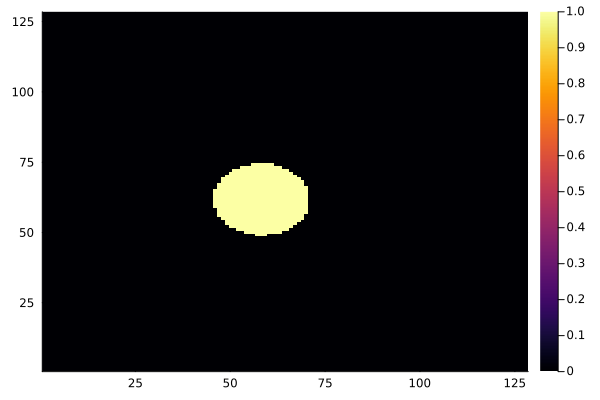

In [14]:
heatmap(x0[:,:,1,1])

In [15]:
y0[:,1]

2-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1

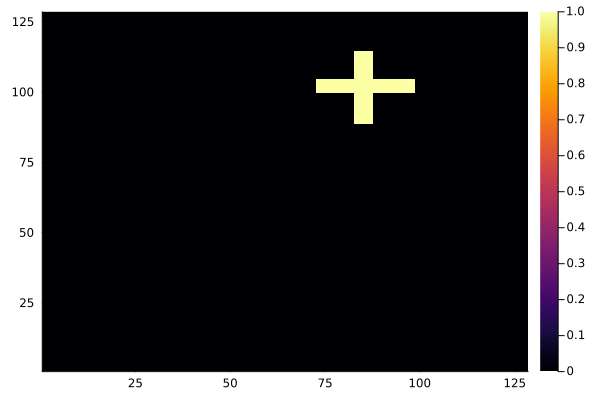

In [16]:
heatmap(x0[:,:,1,10] |> cdev)

In [17]:
y0[:,10]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

In [18]:
gu = glorot_uniform

glorot_uniform (generic function with 8 methods)

In [19]:
l1 = Chain(Conv((32,32), 1=>3, relu, pad=(1,1), init_weight=gu),)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
)         # Total: 3_075 parameters,
          #        plus 0 states.

In [20]:
pc1, st1 = Lux.setup(args.rng, l1) .|> gdev

((layer_1 = (weight = Float32[-0.0034841762 -0.0016821366 … -0.020128593 0.01660142; -0.024986744 -0.036207687 … 0.0072304974 -0.0015313312; … ; 0.004218169 0.027183954 … 0.019954098 -0.014109451; 0.009388219 0.03333457 … 0.03558682 -0.038266618;;;; -0.0049630613 0.024682323 … 0.021205783 0.0053131534; 0.0073187915 0.0011486764 … -0.037837457 -0.0050171455; … ; 0.026581643 -0.005310548 … 0.014991229 0.0014630575; -0.03620977 0.028937288 … -0.022090621 -0.015945118;;;; 0.029828647 -0.02825459 … 0.027455455 0.03651365; 0.024347693 -0.0010327105 … -0.010969956 -0.026191402; … ; -0.013010105 0.0060414975 … 0.034873445 -0.03129835; -0.03079045 0.032877844 … 0.017425781 0.023929806], bias = Float32[-0.013976701, 0.01387392, 0.015629027]),), (layer_1 = NamedTuple(),))

In [21]:
s1, _ = l1(x0 |> gdev, pc1, st1) |> cdev

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.013873909 0.013873906 … 0.013873915 0.013873915; 0.013873915 0.013873912 … 0.013873919 0.013873914; … ; 0.013873923 0.0138739245 … 0.013873928 0.01387393; 0.013873913 0.013873914 … 0.013873914 0.013873918;;; 0.015629021 0.015629018 … 0.01562902 0.015629016; 0.015629033 0.01562903 … 0.015629025 0.015629023; … ; 0.015629033 0.015629034 … 0.015629023 0.015629025; 0.015629038 0.01562904 … 0.015629012 0.015629012;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.08337694 0.0; 0.0 0.0 … 0.11808326 0.015774703;;; 0.013873933 0.013873928 … 0.013873928 0.0138739245; 0.013873922 0.013873923 … 0.013873906 0.013873909; … ; 0.013873933 0.013873882 … 0.0 0.0; 0.013873936 0.0138738975 … 0.0 0.0;;; 0.015629036 0.015629036 … 0.015629046 0.015629044; 0.015629018 0.015629018 … 0.015629038 0.015629034; … ; 0.015629046 0.015629055 … 0.0 0.0; 0.015629025 0.015629055 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 …

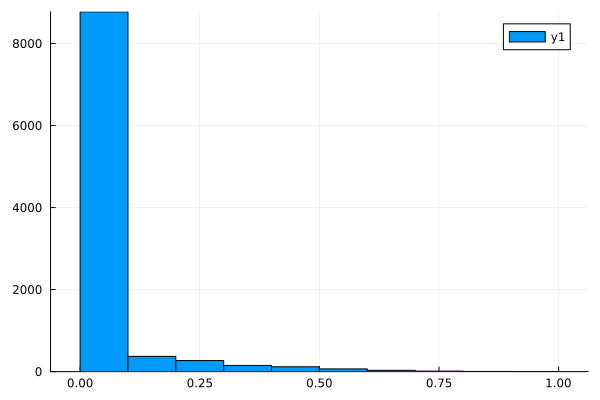

In [22]:
histogram(vec(s1[:,:,1,1]))

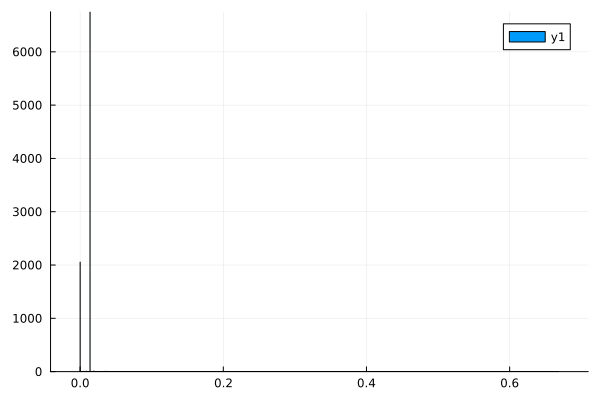

In [23]:
histogram(vec(s1[:,:,2,1]))

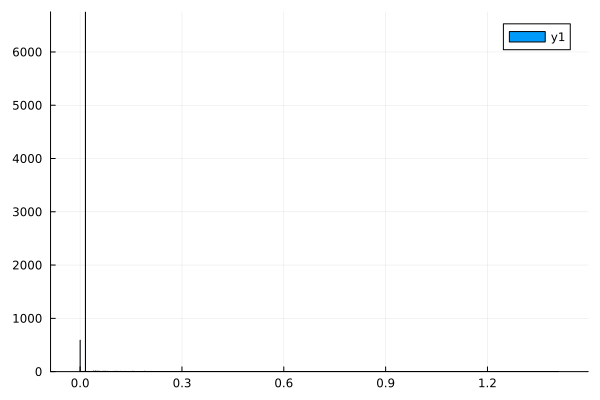

In [24]:
histogram(vec(s1[:,:,3,1]))

In [25]:
gu = glorot_uniform
model = Chain(Conv((32,32), 1=>3, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            Dropout(0.3),

            Conv((16,16), 3=>1, relu, pad=(1,1), init_weight=gu),
            MaxPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),

            Dense(324 => 16, relu, init_weight=gu),
            Dense(16 => 2, init_weight=gu),
            softmax)

Chain(
    layer_1 = Conv((32, 32), 1 => 3, relu, pad=1),  # 3_075 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Dropout(0.3),
    layer_4 = Conv((16, 16), 3 => 1, relu, pad=1),  # 769 parameters
    layer_5 = MaxPool((2, 2)),
    layer_6 = FlattenLayer{Nothing}(nothing),
    layer_7 = Dropout(0.4),
    layer_8 = Dense(324 => 16, relu),             # 5_200 parameters
    layer_9 = Dense(16 => 2),                     # 34 parameters
    layer_10 = WrappedFunction(softmax),
)         # Total: 9_078 parameters,
          #        plus 4 states.

In [26]:
ps, st = Lux.setup(rng, model) .|> gdev

((layer_1 = (weight = Float32[0.027360117 0.004072884 … -0.01807847 -0.032759733; -0.010413798 0.034778245 … 0.035285465 0.029700717; … ; 0.013936236 0.016096503 … 0.0068119536 -0.0050979843; 0.024638558 -0.03759801 … 0.01713775 -0.0017146537;;;; -0.009451081 -0.035764314 … 0.03800448 -0.028433735; 0.019742338 -0.01503904 … -0.029003553 0.019710401; … ; 0.02394051 -0.0042611933 … -0.03424003 -0.012044286; 0.022216065 -0.0075315284 … -0.032815184 -0.00018849639;;;; 0.027850054 -0.01748911 … -0.017920448 -0.0366432; 0.0046768216 0.037568145 … 0.030030968 0.01817868; … ; -0.0033469764 0.0062101926 … -0.024179874 0.034493655; 0.036317687 0.015781939 … -0.023384972 0.010362706], bias = Float32[0.006960854, 0.019366581, -0.0013264604]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.022960067 0.056717463 … -0.07555596 -0.0018904388; 0.02469069 0.007871415 … -0.062392905 0.065183885; … ; 0.030703621 -0.024193693 … 0.020592524 -0.061125997; 0.009805854 0.0667566

In [27]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y)
end

loss_function (generic function with 1 method)

In [28]:
x0 = x0 |> gdev
y0 = y0 |> gdev

2×128 OneHotMatrix(::CuArray{UInt32, 1, CUDA.DeviceMemory}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅
 1  1  1  1  1  1  ⋅  1  1  ⋅  ⋅  1  1     1  1  1  ⋅  1  ⋅  1  ⋅  1  1  1  1

In [29]:
l, gs = withgradient(p -> loss_function(x0, y0, model, p, st), ps)

(val = 0.74465835f0, grad = ((layer_1 = (weight = Float32[-0.00031735678 -0.004736239 … 0.0054427814 0.008125611; 0.0056118984 -0.00290249 … 0.0039036272 0.012330126; … ; 0.03143771 0.030890636 … -0.01479481 -0.015417209; 0.026754122 0.03126192 … -0.012420883 -0.010506136;;;; 0.001543619 -5.0218543f-5 … -0.006225122 -0.0038962339; 0.002209075 -0.0005176248 … 0.00058071275 0.003541018; … ; 0.031185161 0.03207282 … 2.02755f-5 0.0014961993; 0.02886193 0.027719885 … 0.0023569535 0.00090084574;;;; 0.01985274 0.01905661 … 0.012184846 0.010110127; 0.025444191 0.025617106 … 0.010261403 0.014513499; … ; 0.019008175 0.02386566 … -0.0033884204 -0.0040012766; 0.008461396 0.015195014 … 0.0031267372 -0.0019259198], bias = Float32[-0.11947105, -0.023701651, 0.057811648]), layer_2 = nothing, layer_3 = nothing, layer_4 = (weight = Float32[0.017065717 0.01303995 … 0.008302195 0.019041982; 0.009730848 0.016293693 … 0.014013746 0.015466788; … ; 0.018543214 0.011356537 … 0.0115338005 0.010445904; 0.0193812

In [30]:
losses, pst, stt = train(model, ps, st, train_loader, loss_function, args)

[ Info: Training on CUDA GPU


(Any[0.74465835f0, 0.7053575f0, 0.7380618f0, 0.69517934f0, 0.6979648f0, 0.6983737f0, 0.6886363f0, 0.6982419f0, 0.6925905f0, 0.7067141f0  …  0.010559855f0, 0.010707333f0, 0.008991771f0, 0.009235334f0, 0.009507094f0, 0.01111796f0, 0.008364327f0, 0.010030484f0, 0.026748937f0, 0.0056325383f0], (layer_1 = (weight = Float32[0.00873826 -0.036006425 … -0.072161436 -0.13645005; -0.018634789 -0.00234429 … -0.003874162 -0.059113648; … ; -0.06606924 -0.04524266 … 0.0046762633 -0.009358025; -0.06716389 -0.10831724 … 0.01689666 -0.0027011726;;;; -0.10758396 -0.10123333 … -0.046371948 -0.090708554; -0.030838095 -0.023765335 … -0.10761604 -0.03145682; … ; -0.054128338 -0.068797305 … -0.15550548 -0.098276824; -0.04498258 -0.053184878 … -0.14974906 -0.08467861;;;; 0.026716562 -0.011419623 … -0.029039118 -0.03883246; -0.0001270305 0.038849976 … 0.036230534 0.0278252; … ; -0.022039842 0.017102772 … -0.036234856 0.012154215; -0.003920323 0.0036995069 … -0.035340626 -0.0032264213], bias = Float32[-0.0058430

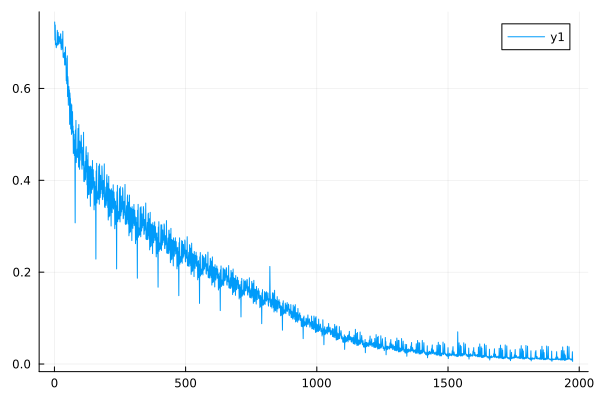

In [31]:
plot(losses)

In [32]:
yh1, _ = model(x0, pst, stt)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/R8Czx/src/utils.jl:334


(Float32[0.02240045 0.017502831 … 0.019503994 0.0194654; 0.97759956 0.98249716 … 0.980496 0.9805346], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (rng = Xoshiro(0x2f955d8e82784d90, 0x37c0a1868004128c, 0xd24c9de1cb693dbe, 0x87a4e3a74a26e167, 0xc90c4a0730db3f7e), training = Val{true}()), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple(), layer_7 = (rng = Xoshiro(0x9ff11faf485abe7b, 0xca1961e9c91562a2, 0xbed4c0676c09702e, 0x5e7d760c88443944, 0xc90c4a0730db3f7e), training = Val{true}()), layer_8 = NamedTuple(), layer_9 = NamedTuple(), layer_10 = NamedTuple()))

In [33]:
test_loader = generate_dataset(rng, 1000, args, noise_level)

8-element DataLoader(::Tuple{Array{Float32, 4}, OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (128×128×1×128 Array{Float32, 4}, 2×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [34]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        true_labels = onecold(y)
        
        total_correct += sum(pred_labels .== true_labels)
        total_samples += size(x, length(size(x)))
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [35]:
test(model, test_loader, ps, st)

0.525

In [36]:
test(model, test_loader, pst, stt)

0.998

# Replicate with Phasor Architecture

In [37]:
import .PhasorNetworks: LuxParams, ComplexBias, PhasorConv

In [38]:
m1 = Chain(PhasorConv((32, 32), 1 => 3, identity, init_weight = gu),)

Chain(
    layer_1 = PhasorConv(
        layer = Conv((32, 32), 1 => 3, use_bias=false),  # 3_072 parameters
        bias = ComplexBias((1, 1, 3)),            # 6 parameters
    ),
)         # Total: 3_078 parameters,
          #        plus 0 states.

In [39]:
psp, stp = Lux.setup(rng, m1) .|> gdev

((layer_1 = (layer = (weight = Float32[-0.0296829 -0.037275504 … -0.0057642506 0.013133143; 0.028966561 0.00623201 … 0.012438215 0.015952267; … ; -0.022337236 -0.030911818 … 0.024241453 0.0039603994; -0.025618326 0.013320102 … -0.0006018571 0.031183636;;;; -0.001888664 0.017292779 … 0.02359118 -0.007374559; -0.0022908694 0.011594827 … -0.030151622 -0.003959884; … ; 0.026384803 -0.024255762 … -0.019276626 0.033002947; 0.011240396 0.026873628 … -0.029010963 -0.009456939;;;; 0.0013685218 0.01781768 … -0.01889062 -0.01964737; 0.016949732 0.018542662 … 0.010009544 0.036979374; … ; -0.03534447 0.030253472 … 0.0056635053 -0.022602584; 0.028095929 -0.016630888 … 0.0066681975 -0.007702067],), bias = (bias_real = Float32[1.0;;; 1.0;;; 1.0], bias_imag = Float32[0.0;;; 0.0;;; 0.0])),), (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [40]:
psp.layer_1.bias.bias_imag

1×1×3 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 0.0

[:, :, 2] =
 0.0

[:, :, 3] =
 0.0

In [41]:
psp.layer_1.bias.bias_real

1×1×3 CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 1.0

[:, :, 2] =
 1.0

[:, :, 3] =
 1.0

In [42]:
import .PhasorNetworks: soft_angle, pi_f32

In [43]:
import ChainRulesCore: ignore_derivatives

In [44]:
yp0, _ = m1(x0, psp, stp) |> cdev;

In [54]:
struct MinPool <: Lux.AbstractLuxContainerLayer{(:layer)}
    layer::MaxPool
end

# Constructor that takes same args as MaxPool
MinPool(kernel_size; kwargs...) = MinPool(MaxPool(kernel_size; kwargs...))

# Forward pass implementation
function (mp::MinPool)(x, ps, st)
    y, st = mp.layer(-1.0f0 .* x, ps, st)
    return -1.0f0 .* y, st
end

function Lux.initialparameters(rng::AbstractRNG, pool::MinPool)
    st_layer = Lux.initialparameters(rng, pool.layer)
    return st_layer
end

function Lux.initialstates(rng::AbstractRNG, pool::MinPool)
    st_layer = Lux.initialstates(rng, pool.layer)
    return st_layer
end

In [55]:
# p_model = Chain(LayerNorm((128,128,1)),
#             x -> tanh.(x),
#             PhasorConv((32,32), 1=>3, pad=(1,1), complex_to_angle, init_weight=gu, init_bias = nothing),
#             MinPool((2,2)),
#             Dropout(0.3),

#             PhasorConv((16,16), 3=>1, pad=(1,1), complex_to_angle, init_weight=gu, init_bias = nothing),
#             MinPool((2,2)),
#             FlattenLayer(),
#             Dropout(0.4),
            
#             PhasorDense(324 => 16, complex_to_angle, init_weight=gu),
#             PhasorDense(16 => 2, complex_to_angle, init_weight=gu),
#             );

In [56]:
using NNlib: lpnormpool

In [57]:
p_model = Chain(LayerNorm((128,128,1)),
            x -> tanh.(x),
            PhasorConv((32,32), 1=>3, pad=(1,1), soft_angle, init_weight=gu, init_bias = nothing),
            MeanPool((2,2)),
            Dropout(0.3),

            PhasorConv((16,16), 3=>1, pad=(1,1), soft_angle, init_weight=gu, init_bias = nothing),
            MeanPool((2,2)),
            FlattenLayer(),
            Dropout(0.4),
            
            PhasorDense(324 => 324, complex_to_angle, init_weight=gu),
            Codebook(324 => 2),
            );

In [58]:
pps, pst = Lux.setup(rng, p_model) .|> gdev

((layer_1 = (bias = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;;], scale = Float32[1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;;;]), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.034795083 -0.0086943535 … 0.008206276 0.01789986; -0.00065760204 -0.008823984 … 0.013021831 0.027889488; … ; 0.0070637367 0.004193175 … -0.025830096 -0.012434259; -0.0084408 -0.032943744 … -0.015533482 -0.021490742;;;; -0.01985365 0.024278447 … -0.01972892 0.019641273; -0.0027004841 -0.0019115497 … -0.014254932 -0.022607215; … ; 0.03464424 -0.019377122 … 0.03751495 0.029511131; 0.0025498432 -0.0031661086 … 0.0120763425 -0.03154856;;;; -0.013307213 -0.022710351 … 0.0117038805 -0.006670383; -0.032761868 -0.012114326 … -0.028732475 -0.0149793755; … ; -0.017184703 0.025240324 … 0.020163734 -0.017606882; 0.032012366 0.023162616 … 0.011922106 0.027120352],), bias = (bias_real = Float32[0.0;;; 0.0;;; 0.0], bias_imag = F

In [59]:
yhp0, _ = p_model(x0 |> gdev, pps, pst)

(Float32[0.040334832 0.0020619156 … 0.03001228 -0.02361862; -0.010034038 0.026862668 … 0.027968515 0.027827693], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (rng = Xoshiro(0x104a45853e819083, 0x6d4030a4fe25dd0a, 0xa920b7f79387cb97, 0x684accacd75dbb45, 0xc90c4a0730db3f7e), training = Val{true}()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = NamedTuple(), layer_9 = (rng = Xoshiro(0x1540b98d17f9f6cc, 0xd42ac2d65323861e, 0xd8230e3917125b14, 0x0cc9e0a15f81052f, 0xc90c4a0730db3f7e), training = Val{true}()), layer_10 = (dense = NamedTuple(), bias = NamedTuple()), layer_11 = NamedTuple()))

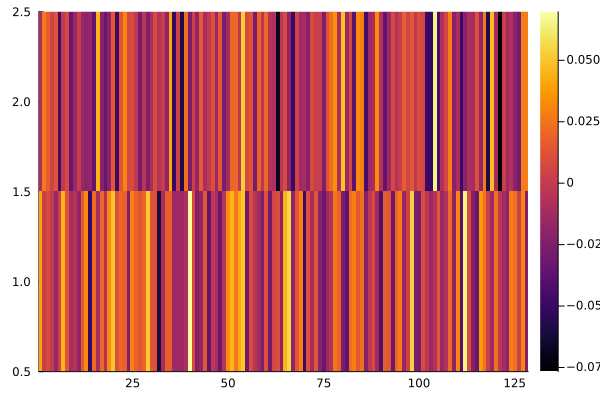

In [60]:
heatmap(yhp0 |> cdev)

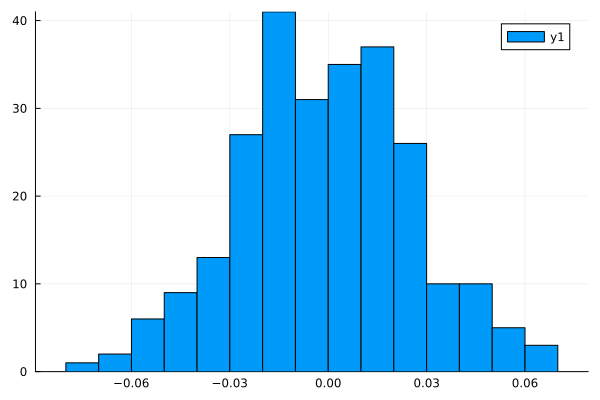

In [61]:
histogram(vec(cdev(yhp0)))

In [62]:
codebook_loss(yhp0, y0) |> mean

0.50201654f0

In [63]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    loss = codebook_loss(y_pred, y) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [64]:
l2, gs2 = withgradient(p -> phasor_loss_function(x0, y0, p_model, p, pst), pps)

(val = 0.50201654f0, grad = ((layer_1 = (bias = Float32[-1.0975868f-5 2.7467252f-7 … -5.0597737f-7 -1.5319631f-6; -2.8270366f-5 1.19506585f-5 … 5.777383f-6 3.0316455f-6; … ; 1.2425517f-6 9.825698f-6 … 3.9608267f-6 2.0738103f-6; -1.4753016f-6 9.803929f-6 … 2.9399814f-6 8.9801017f-7;;;;], scale = Float32[1.6292599f-6 -4.076417f-8 … 7.510706f-8 2.2740393f-7; 4.1964386f-6 -1.7739554f-6 … -8.575922f-7 -4.500161f-7; … ; -1.8446076f-7 -1.4585528f-6 … -5.8794336f-7 -3.0783548f-7; 2.1898988f-7 -1.455291f-6 … -4.3640955f-7 -1.3330023f-7;;;;]), layer_2 = nothing, layer_3 = (layer = (weight = Float32[0.0036547524 0.0036918335 … 0.0052280426 0.0053171376; 0.0037931195 0.0038962886 … 0.0052211042 0.005256202; … ; -0.00093480106 -0.0011235089 … 0.00034084357 0.0011628754; -0.0005526962 -0.00070588384 … 0.0015962087 0.0006481386;;;; -0.0043245014 -0.0044719805 … -0.004050236 -0.004193552; -0.0044879857 -0.0045590037 … -0.0038809516 -0.0037682354; … ; -0.003826317 -0.004959123 … 0.0010353844 0.00133848

In [65]:
args = Args(batchsize = 128, epochs = 40, lr=0.0003)

Args(0.0003, 128, 40, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [66]:
p_losses, ppst, pstp = train(p_model, pps, pst, train_loader, phasor_loss_function, args, optimiser=Optimisers.RMSProp)

[ Info: Training on CUDA GPU


(Any[0.50201654f0, 0.48600394f0, 0.46702304f0, 0.46109018f0, 0.44951585f0, 0.4252526f0, 0.4017436f0, 0.38374108f0, 0.36783206f0, 0.35594308f0  …  0.045296073f0, 0.06847907f0, 0.051832937f0, 0.05335314f0, 0.050174166f0, 0.0666767f0, 0.052565288f0, 0.07659422f0, 0.06982798f0, 0.11198874f0], (layer_1 = (bias = Float32[-0.060758065 -0.10777467 … -0.07466043 0.0034675098; -0.049262322 -0.08463921 … -0.093895674 -0.06170251; … ; 0.013146501 0.016134534 … -0.010515003 -0.010021112; -0.12344353 0.09423408 … 0.016812366 0.045755107;;;;], scale = Float32[1.0620339 1.1095892 … 1.0712844 0.9919838; 1.0514569 1.0861796 … 1.0970852 1.0572734; … ; 0.98748463 0.9874668 … 1.0073894 1.007003; 1.1069599 0.9176559 … 0.9823369 0.95538074;;;;]), layer_2 = NamedTuple(), layer_3 = (layer = (weight = Float32[0.09080217 0.030901352 … -0.0034574978 0.008132896; 0.043425705 0.020994939 … 0.0073955045 0.024012191; … ; 0.0040267194 -0.0077864146 … 0.012354943 0.018455857; -0.0145800235 -0.047988586 … 0.018404394 0.

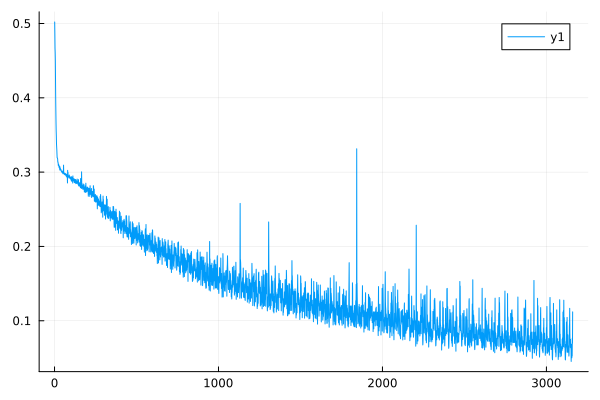

In [67]:
plot(p_losses)

In [68]:
yhp1, _ = p_model(x0, ppst, pstp)

(Float32[0.3996502 -0.016102044 … 0.14211227 -0.04396364; 0.3759124 0.75731516 … 0.7081448 0.8122803], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = (layer = NamedTuple(), bias = NamedTuple()), layer_4 = NamedTuple(), layer_5 = (rng = Xoshiro(0x104a45853e819083, 0x6d4030a4fe25dd0a, 0xa920b7f79387cb97, 0x684accacd75dbb45, 0xc90c4a0730db3f7e), training = Val{true}()), layer_6 = (layer = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple(), layer_8 = NamedTuple(), layer_9 = (rng = Xoshiro(0x1540b98d17f9f6cc, 0xd42ac2d65323861e, 0xd8230e3917125b14, 0x0cc9e0a15f81052f, 0xc90c4a0730db3f7e), training = Val{true}()), layer_10 = (dense = NamedTuple(), bias = NamedTuple()), layer_11 = NamedTuple()))

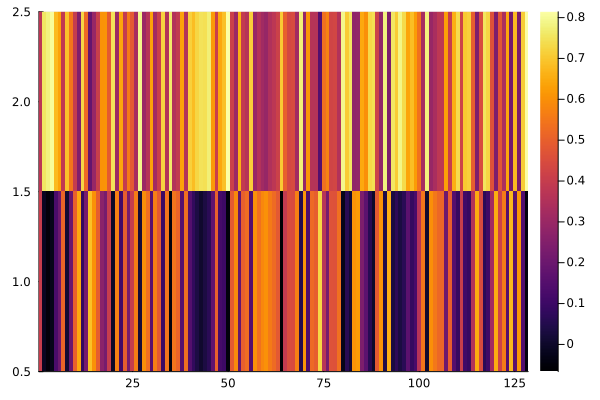

In [69]:
heatmap(yhp1 |> cdev)

In [70]:
xs = -1.0:0.01:1.0 .* pi;

In [71]:
distances = vec(cdev(1.0 .* y0) .- (cdev(yhp1)));

In [72]:
xs = 0.0:0.01:2.0

0.0:0.01:2.0

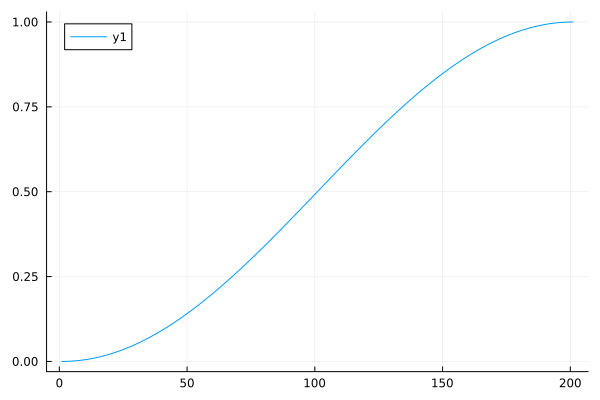

In [73]:
plot(sin.(pi/4 .* xs) .^ 2.0)

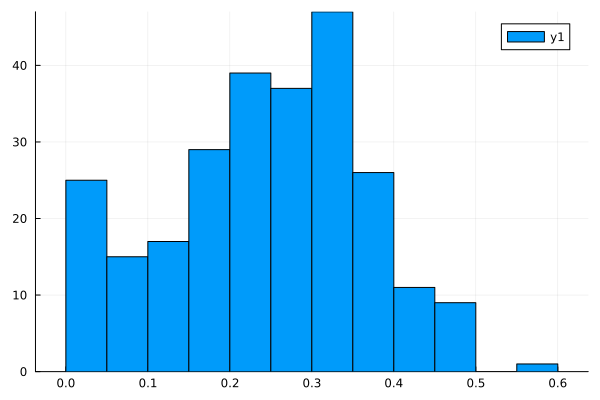

In [74]:
histogram(sin.(pi/4 .* abs.(distances)))

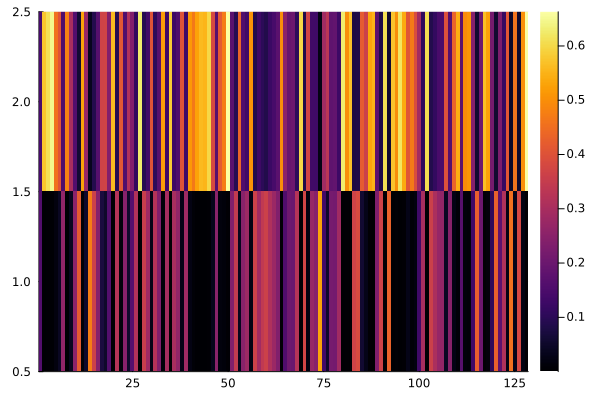

In [75]:
heatmap(abs2.(yhp1) |> cdev)

In [76]:
import .PhasorNetworks: loss_and_accuracy, SpikingTypes, predict_codebook, on_gpu

In [77]:
loss_and_accuracy(test_loader, p_model, ppst, pstp, args)

(0.29257655f0, 0.938)